In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import os

🚀 Entrenamiento de CONTORNOS - TODAS LAS CARACTERÍSTICAS (SIN SCALER NI SELECTOR)
✅ Archivo encontrado en: ..\data_augmentation\contornos_features_aug.xlsx
📊 Datos cargados: (4000, 47)
Índices de etiqueta presentes en el archivo: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Remapeo etiquetas: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3}
CLASSES actualizadas: ['argollas', 'zetas', 'tensores', 'zetasr']

📈 Análisis inicial del dataset:
📊 Forma del dataset: (4000, 47)
📊 Características totales: 46
📊 Distribución de clases (índice -> nombre):
  0 -> argollas: 1000 muestras
  1 -> zetas: 1000 muestras
  2 -> tensores: 1000 muestras
  3 -> zetasr: 1000 muestras

🔄 Balanceando dataset a 1000 muestras por clase...
  argollas: 1000 → 1000 (sin cambios)
  zetas: 1000 → 1000 (sin cambios)
  tensores: 1000 → 1000 (sin cambios)
  zetasr: 1000 → 1000 (sin cambios)
✅ Dataset balanceado: 4000 muestras totales

📊 Train: 3000 muestras | Test: 1000 muestras
🏷️ Clases presentes

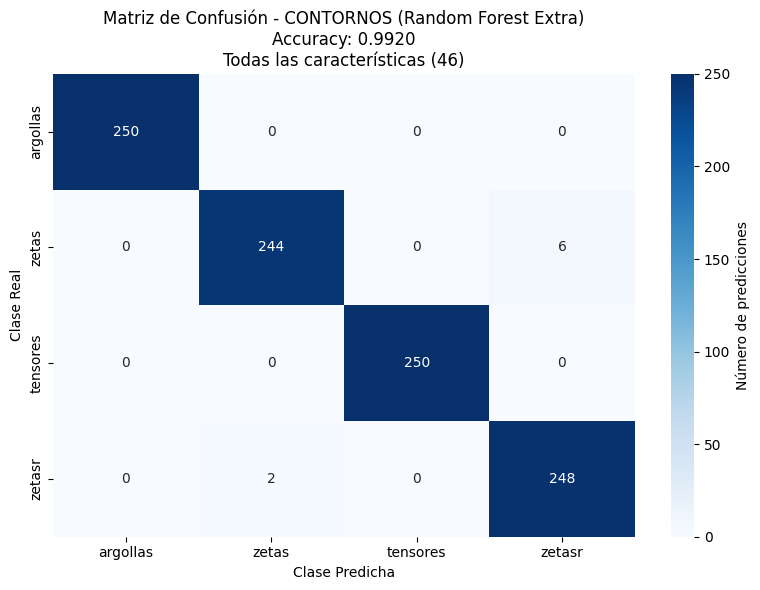


❌ ERRORES MÁS COMUNES:
  zetas → zetasr: 6 veces (75.0%)
  zetasr → zetas: 2 veces (25.0%)

💾 Guardando mejor modelo...
✅ Modelo guardado: ..\gui\modelos\modelo_contornos_TODAS_CARACTERISTICAS.pkl
✅ Características utilizadas: 46

🎉 RESUMEN FINAL DEL ENTRENAMIENTO DE CONTORNOS (TODAS LAS CARACTERÍSTICAS)
📊 Dataset balanceado: 4000 muestras
🔍 Características utilizadas: TODAS (46 características)
🏆 Mejor modelo: Random Forest Extra
🎯 Mejor accuracy: 0.9920

✨ ¡Entrenamiento completado!


In [2]:
# ===== MODELO PARA CONTORNOS (argollas, zetas, ochos, tensores) - TODAS LAS CARACTERÍSTICAS =====
# Instalar XGBoost si no está disponible
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    print("⚠️ XGBoost no disponible. Instalando...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    from xgboost import XGBClassifier
    xgb_available = True

# CLASES que tienes
CLASSES = ["argollas", "zetas", "tensores","zetasr"]
TARGET_SAMPLES_PER_CLASS = 1000  # ajusta si quieres otro objetivo

print("🚀 Entrenamiento de CONTORNOS - TODAS LAS CARACTERÍSTICAS (SIN SCALER NI SELECTOR)")
print("="*80)

def cargar_datos_contornos():
    """Busca y carga el archivo de características generado por data_augmentation"""
    rutas_posibles = [
        os.path.join("..", "data_augmentation", "contornos_features_aug.xlsx"),
        os.path.join("data_augmentation", "contornos_features_aug.xlsx"),
        os.path.join("..", "proyecto_final", "data_augmentation", "contornos_features_aug.xlsx"),
        "contornos_features_aug.xlsx"
    ]
    for ruta in rutas_posibles:
        if os.path.exists(ruta):
            print(f"✅ Archivo encontrado en: {ruta}")
            try:
                df = pd.read_excel(ruta, header=None, engine='openpyxl')
                print(f"📊 Datos cargados: {df.shape}")
                return df, ruta
            except Exception as e:
                print(f"❌ Error cargando {ruta}: {e}")
                continue
    print("❌ No se encontró el archivo de features. Genera el XLSX desde data_augmentation.")
    return None, None

# Cargar datos
df_contornos, archivo_path = cargar_datos_contornos()
if df_contornos is None:
    raise SystemExit("Archivo de features no encontrado. Ejecuta data_augmentation primero.")

# (coloca este bloque inmediatamente después de cargar df_contornos)
present_indices = sorted(df_contornos.iloc[:, 0].unique())
print(f"Índices de etiqueta presentes en el archivo: {present_indices}")

# CLASSES original (la que definiste); la usamos como referencia de nombres por índice
CLASSES_ORIG = CLASSES  # ...existing code... (por si CLASSES ya está definida arriba)

# Construir lista de nombres usada y remapear etiquetas a 0..N-1
classes_used = []
for idx in present_indices:
    if idx < len(CLASSES_ORIG):
        classes_used.append(CLASSES_ORIG[idx])
    else:
        classes_used.append(f"class_{int(idx)}")

# Remap viejo -> nuevo (0..len(classes_used)-1)
map_old_to_new = {old: new for new, old in enumerate(present_indices)}
print(f"Remapeo etiquetas: {map_old_to_new}")
# Aplicar remapeo en DataFrame (primera columna)
df_contornos.iloc[:, 0] = df_contornos.iloc[:, 0].map(map_old_to_new)

# Reemplazar CLASSES por las clases realmente presentes (ordenadas por el nuevo índice)
CLASSES = classes_used
print(f"CLASSES actualizadas: {CLASSES}")

# Análisis inicial
print(f"\n📈 Análisis inicial del dataset:")
print(f"📊 Forma del dataset: {df_contornos.shape}")
print(f"📊 Características totales: {df_contornos.shape[1] - 1}")  # -1 por label

class_counts = df_contornos.iloc[:, 0].value_counts().sort_index()
print("📊 Distribución de clases (índice -> nombre):")
for idx, count in class_counts.items():
    name = CLASSES[int(idx)] if int(idx) < len(CLASSES) else f"class_{int(idx)}"
    print(f"  {int(idx)} -> {name}: {count} muestras")

# Balanceo (resample) por clase al objetivo
def balance_dataset(df, target_samples_per_class=TARGET_SAMPLES_PER_CLASS):
    balanced_dfs = []
    print(f"\n🔄 Balanceando dataset a {target_samples_per_class} muestras por clase...")
    for class_label in sorted(df.iloc[:, 0].unique()):
        class_data = df[df.iloc[:, 0] == class_label]
        current_samples = len(class_data)
        name = CLASSES[int(class_label)] if int(class_label) < len(CLASSES) else str(class_label)
        if current_samples > target_samples_per_class:
            balanced_class = resample(class_data, n_samples=target_samples_per_class, random_state=42)
            action = "reducido"
        elif current_samples < target_samples_per_class:
            balanced_class = resample(class_data, n_samples=target_samples_per_class, random_state=42, replace=True)
            action = "aumentado"
        else:
            balanced_class = class_data
            action = "sin cambios"
        balanced_dfs.append(balanced_class)
        print(f"  {name}: {current_samples} → {target_samples_per_class} ({action})")
    balanced_df = pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"✅ Dataset balanceado: {len(balanced_df)} muestras totales")
    return balanced_df

# Balancear y preparar X,y
df_balanced = balance_dataset(df_contornos, TARGET_SAMPLES_PER_CLASS)
y = df_balanced.iloc[:, 0].astype(int)
X = df_balanced.iloc[:, 1:]

# Limpieza
if X.isnull().sum().sum() > 0:
    X = X.fillna(0)
if np.isinf(X.values).sum() > 0:
    X = X.replace([np.inf, -np.inf], 0)

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\n📊 Train: {X_train.shape[0]} muestras | Test: {X_test.shape[0]} muestras")
print(f"🏷️ Clases presentes: {sorted(y.unique())} -> {[CLASSES[i] if i < len(CLASSES) else str(i) for i in sorted(y.unique())]}")

# Modelos (mismos hiperparámetros que tenías)
models = {
    'Random Forest Robusto': RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2,
        max_features='sqrt', random_state=42, class_weight='balanced', bootstrap=True,
        oob_score=True, n_jobs=-1
    ),
    'XGBoost Potente': XGBClassifier(
        n_estimators=800, max_depth=10, learning_rate=0.01, subsample=0.9,
        colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.5, random_state=42,
        eval_metric='mlogloss', use_label_encoder=False, verbosity=0, n_jobs=-1
    ),
    'Random Forest Extra': RandomForestClassifier(
        n_estimators=1000, max_depth=25, min_samples_split=3, min_samples_leaf=1,
        max_features='log2', random_state=42, class_weight='balanced', bootstrap=True, oob_score=True, n_jobs=-1
    )
}

# Entrenamiento y evaluación
print(f"\n🎯 Entrenando {len(models)} modelos...")
best_model = None
best_accuracy = 0
best_name = ""
all_results = {}

for name, model in models.items():
    print(f"\n🔄 Entrenando {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"✅ {name}: {accuracy:.4f} accuracy")
        if hasattr(model, 'oob_score_'):
            print(f"   📊 OOB Score: {model.oob_score_:.4f}")
        all_results[name] = {'model': model, 'accuracy': accuracy, 'predictions': y_pred}
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_name = name
    except Exception as e:
        print(f"❌ Error entrenando {name}: {e}")

# Resultados y ranking
print(f"\n🏆 MEJOR MODELO: {best_name} con {best_accuracy:.4f} accuracy")
print(f"\n📊 RANKING DE TODOS LOS MODELOS:")
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for i, (name, results) in enumerate(sorted_results, 1):
    print(f"  {i}. {name}: {results['accuracy']:.4f}")

# Análisis detallado del mejor modelo
if best_model is not None:
    y_pred_best = all_results[best_name]['predictions']
    print(f"\n📈 REPORTE DETALLADO DE {best_name}:")
    print("="*60)
    print(classification_report(y_test, y_pred_best, target_names=[CLASSES[i] for i in sorted(y.unique())], zero_division=0))

    # Matriz de confusión con nombres de clase reales
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_best)
    class_names = [CLASSES[i] for i in range(len(CLASSES))]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Número de predicciones'})
    plt.title(f'Matriz de Confusión - CONTORNOS ({best_name})\nAccuracy: {best_accuracy:.4f}\nTodas las características ({X.shape[1]})')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.tight_layout()
    plt.show()

    # Errores más comunes (mapeados a nombres)
    errors = y_test != y_pred_best
    if errors.sum() > 0:
        print(f"\n❌ ERRORES MÁS COMUNES:")
        error_pairs = list(zip(y_test[errors], y_pred_best[errors]))
        from collections import Counter
        common_errors = Counter(error_pairs).most_common(10)
        for (real, pred), count in common_errors:
            real_name = CLASSES[int(real)]
            pred_name = CLASSES[int(pred)]
            print(f"  {real_name} → {pred_name}: {count} veces ({count/errors.sum()*100:.1f}%)")

    # Guardar mejor modelo
    print(f"\n💾 Guardando mejor modelo...")
    modelos_path = os.path.join("..", "gui", "modelos")
    os.makedirs(modelos_path, exist_ok=True)
    modelo_file = os.path.join(modelos_path, 'modelo_contornos_TODAS_CARACTERISTICAS.pkl')
    joblib.dump(best_model, modelo_file)
    print(f"✅ Modelo guardado: {modelo_file}")
    print(f"✅ Características utilizadas: {X.shape[1]}")

# Resumen final
print(f"\n{'='*80}")
print("🎉 RESUMEN FINAL DEL ENTRENAMIENTO DE CONTORNOS (TODAS LAS CARACTERÍSTICAS)")
print(f"📊 Dataset balanceado: {len(df_balanced)} muestras")
print(f"🔍 Características utilizadas: TODAS ({X.shape[1]} características)")
print(f"🏆 Mejor modelo: {best_name}")
print(f"🎯 Mejor accuracy: {best_accuracy:.4f}")
print(f"\n✨ ¡Entrenamiento completado!")

In [4]:
# Comprueba existencia de best_model
if 'best_model' not in globals() or best_model is None:
    print("❌ 'best_model' no está definido. Ejecuta la celda de entrenamiento primero.")
else:
    try:
        # Determinar carpeta base del script/notebook
        try:
            base_dir = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            base_dir = os.getcwd()

        # Pedir nombre de archivo (enter para usar el por defecto)
        default_name = 'modelo_contornos_TODAS_CARACTERISTICAS.pkl'
        fname = input(f"Nombre archivo [{default_name}]: ").strip() or default_name
        if not fname.lower().endswith('.pkl'):
            fname += '.pkl'

        # Preguntar si guardar en subcarpeta 'models'
        usar_subcarpeta = input("Guardar en subcarpeta 'models' en la carpeta base? (Y/n): ").strip().lower()
        if usar_subcarpeta in ('', 'y', 's', 'si', 'yes'):
            save_dir = os.path.join(base_dir, 'models')
            os.makedirs(save_dir, exist_ok=True)
        else:
            save_dir = base_dir

        modelo_file = os.path.join(save_dir, fname)
        joblib.dump(best_model, modelo_file)
        print(f"✅ Modelo guardado en: {modelo_file}")
    except Exception as e:
        print(f"❌ Error guardando el modelo: {e}")

✅ Modelo guardado en: e:\Documents\Decimo\VisionArtificial\proyecto_final_vision_artificial_202502\proyecto_final\train\models\famlily_model.pkl
